In [35]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tifffile as tiff
from PIL import Image
from sklearn.model_selection import train_test_split


In [36]:
# Reproducability
def set_seed(seed=125):
    np.random.seed(seed)
    tf.random.set_seed(seed)

    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed(125)


In [37]:
BATCH_SIZE = 16
IMG_SIZE = 128

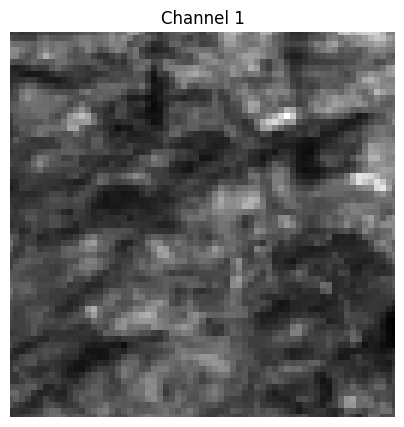

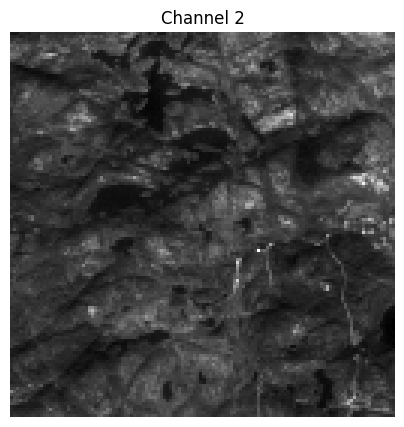

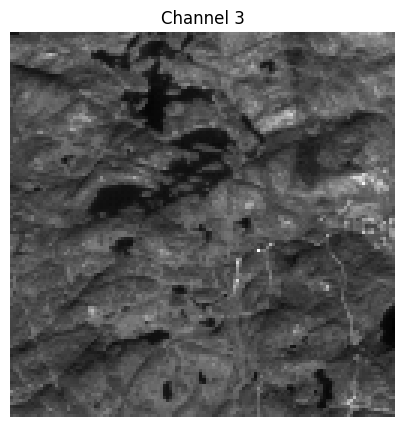

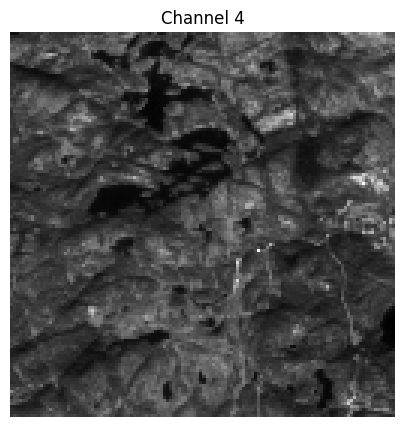

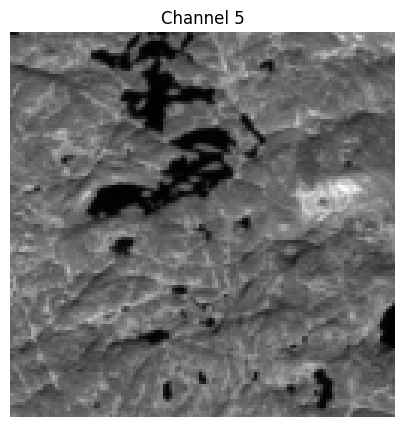

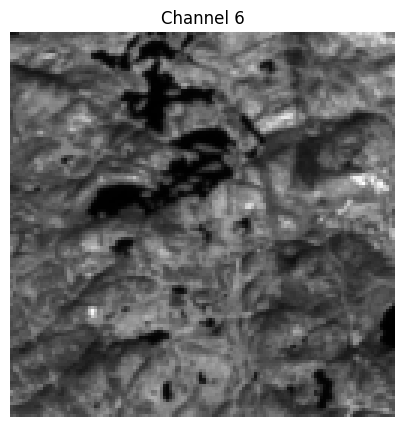

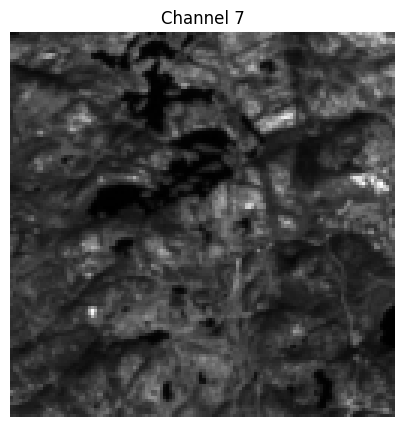

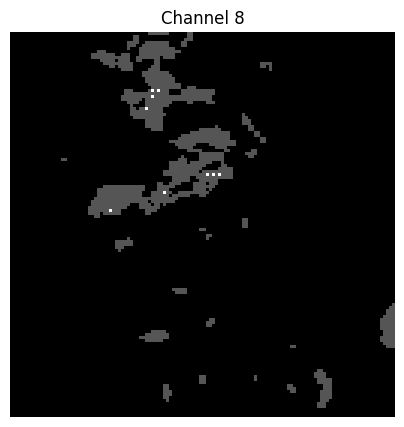

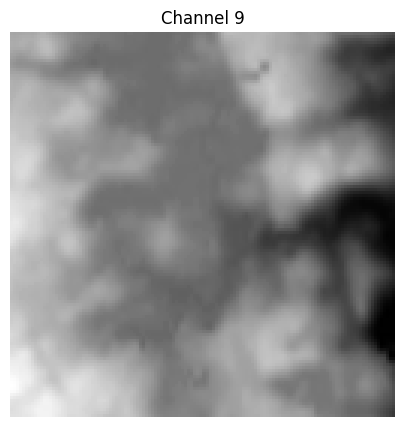

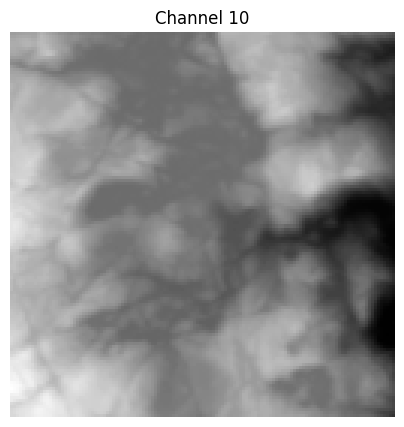

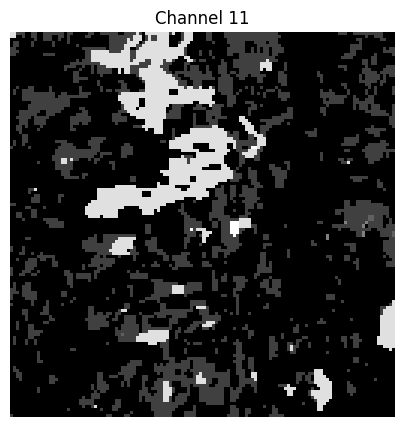

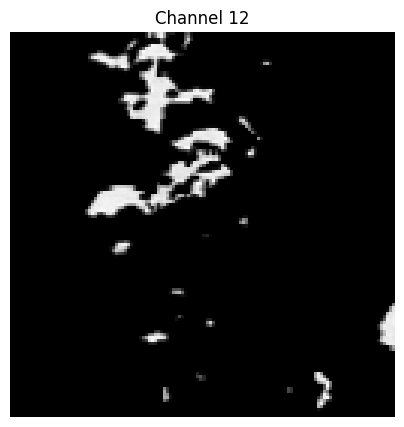

In [38]:
# Read the TIFF file
tif_path = 'data/images/0.tif'  
tif_image = tiff.imread(tif_path)

# Check the number of channels
num_channels = tif_image.shape[2]

# Plot each channel
for i in range(num_channels):
    plt.figure(figsize=(5, 5))
    plt.imshow(tif_image[:,:,i], cmap='gray')
    plt.title(f'Channel {i + 1}')
    plt.axis('off')
    plt.show()

In [39]:
tif_image.shape

(128, 128, 12)

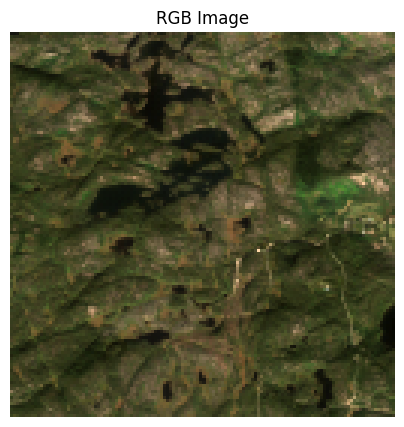

In [40]:
#get the rgb channels
rgb_image = tif_image[:,:,1:4]
rgb_image = rgb_image[:,:,::-1]
# Normalize the image data to the range 0-1
rgb_image = rgb_image.astype(np.float32)
rgb_image -= rgb_image.min()  
rgb_image /= rgb_image.max()  
rgb_image *= 255.0

# Convert to uint8 type
rgb_image = rgb_image.astype(np.uint8)

# Plot the RGB image
plt.figure(figsize=(5, 5))
plt.imshow(rgb_image)
plt.title('RGB Image')
plt.axis('off')
plt.show()

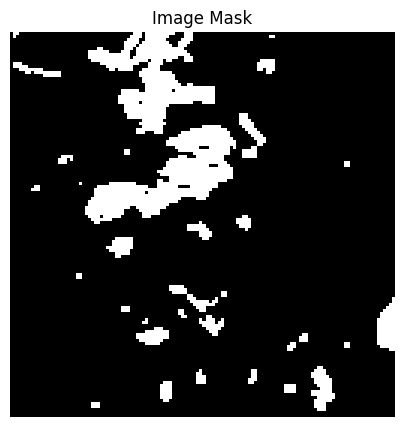

In [41]:
# Read the image mask
png_path = 'data/labels/0.png'  
png_image = Image.open(png_path)

# Plot the image
plt.figure(figsize=(5, 5))
plt.imshow(png_image, cmap='gray')
plt.title('Image Mask')
plt.axis('off')
plt.show()

In [42]:
# Paths
img_dir = "data/images"
label_dir = "data/labels"

In [43]:
# Get exact image base names 
image_files = {os.path.splitext(f)[0] for f in os.listdir(img_dir) if f.endswith('.tif')}
label_files = os.listdir(label_dir)

# Remove labels that don't match an image filename 
for label_file in label_files:
    base_name = os.path.splitext(label_file)[0]  # No splitting by underscore now
    if base_name not in image_files:
        os.remove(os.path.join(label_dir, label_file))
num_images = len([f for f in os.listdir(img_dir) if f.endswith('.tif')])
num_labels = len([f for f in os.listdir(label_dir) if f.endswith('.png')])

print(f"Number of images in '{img_dir}': {num_images}")
print(f"Number of labels in '{label_dir}': {num_labels}")

Number of images in 'data/images': 306
Number of labels in 'data/labels': 306


In [44]:
# Function to compute per-channel max values
def get_max_of_channels(image_dir):
    image_maxs = np.full(12, -np.inf)
    for image_name in os.listdir(image_dir):
        if image_name.endswith('.tif'):
            image_path = os.path.join(image_dir, image_name)
            image = tiff.imread(image_path)
            image_maxs = np.maximum(image_maxs, image.max(axis=(0,1)))
    return image_maxs

# Function to compute per-channel min values
def get_min_of_channels(image_dir):
    image_mins = np.full(12, np.inf)
    for image_name in os.listdir(image_dir):
        if image_name.endswith('.tif'):
            image_path = os.path.join(image_dir, image_name)
            image = tiff.imread(image_path)
            image_mins = np.minimum(image_mins, image.min(axis=(0,1)))
    return image_mins

image_maxs = get_max_of_channels(img_dir)
image_mins = get_min_of_channels(img_dir)

print(image_maxs)
print(image_mins)

[ 6568.  9659. 11368. 12041. 15841. 15252. 14647.   255.  4245.  4287.
   100.   111.]
[-1.393e+03 -1.169e+03 -7.220e+02 -6.840e+02 -4.120e+02 -3.350e+02
 -2.580e+02  6.400e+01 -9.999e+03  8.000e+00  1.000e+01  0.000e+00]


In [45]:
# Load and preprocess images
def load_image(image_path, label_path):
    image = tiff.imread(image_path).astype(np.float32)
    label = np.array(Image.open(label_path)).astype(np.float32)
    if label.max() > 1:
        label /= 255.0  # Normalize label if in range [0,255]
    return image, label

#normalize images
def preprocess_image(image):
    for i in range(image.shape[2]):
        min_val, max_val = image_mins[i], image_maxs[i]
        if max_val > min_val:  
            image[:, :, i] = (image[:, :, i] - min_val) / (max_val - min_val)
    return image.astype(np.float32)

def load_data(image_dir, label_dir):
    images, labels = [], []
    for image_name in os.listdir(image_dir):
        if image_name.endswith('.tif'):
            image_path = os.path.join(image_dir, image_name)
            label_path = os.path.join(label_dir, image_name.replace('.tif', '.png'))
            if os.path.exists(label_path):
                image, label = load_image(image_path, label_path)
                images.append(preprocess_image(image))
                labels.append(label)
    return np.array(images), np.array(labels)

images, labels = load_data(img_dir, label_dir)
print("After Normalization:")
print("Min pixel value:", images.min(), ", Max pixel value:", images.max())

After Normalization:
Min pixel value: 0.0 , Max pixel value: 1.0


In [47]:
train_images, temp_images, train_labels, temp_labels = train_test_split(
    images, labels, test_size=0.2, random_state=125
)

val_images, test_images, val_labels, test_labels = train_test_split(
    temp_images, temp_labels, test_size=0.5, random_state=125
)

# Check the shapes
print(f"Training set: {train_images.shape}, {train_labels.shape}")
print(f"Validation set: {val_images.shape}, {val_labels.shape}")
print(f"Testing set: {test_images.shape}, {test_labels.shape}")

Training set: (244, 128, 128, 12), (244, 128, 128)
Validation set: (31, 128, 128, 12), (31, 128, 128)
Testing set: (31, 128, 128, 12), (31, 128, 128)


### model architecture & training

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import segmentation_models_pytorch as smp
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score as f1_score_sklearn


class UNetModel(nn.Module):
    def __init__(self, encoder):
        super(UNetModel, self).__init__()
        self.pre_conv = nn.Conv2d(12, 3, kernel_size=1)
        self.unet = smp.Unet(
            encoder_name=encoder,
            encoder_weights='imagenet',
            in_channels=3,
            classes=1,
            activation=None
        )

    def forward(self, x):
        x = self.pre_conv(x)
        return self.unet(x)

class DiceCoefficient(nn.Module):
    def __init__(self):
        super(DiceCoefficient, self).__init__()

    def forward(self, y_pred, y_true):
        y_pred = y_pred > 0.5 
        y_true = y_true.byte()  
        y_pred_flat = torch.flatten(y_pred)
        y_true_flat = torch.flatten(y_true)
        intersection = torch.sum(y_pred_flat * y_true_flat).float()
        union = torch.sum(y_pred_flat) + torch.sum(y_true_flat).float()
        dice= (2. * intersection + 1e-8) / (union + 1e-8)
        return dice
    
def prepare_data(X_train, y_train, X_val, y_val):
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).squeeze(-1)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).permute(0, 3, 1, 2)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).squeeze(-1)
    
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
    
    return train_loader, val_loader

def calculate_f1_score(y_true, y_pred):
    return f1_score_sklearn(y_true.flatten(), y_pred.flatten() > 0.5)

def calculate_accuracy(y_true, y_pred):
    return accuracy_score(y_true.flatten(), y_pred.flatten() > 0.5)

def train(model, train_loader, val_loader, num_epochs=50, patience=10):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
    early_stopping_counter = 0
    best_val_loss = float('inf')
    best_model_state = None
    
    train_losses = []
    val_losses = []
    train_dice_scores = []
    val_dice_scores = []
    dice_coeff = DiceCoefficient()
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        dice_sum = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.view_as(outputs))
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            dice_sum += dice_coeff(torch.sigmoid(outputs), labels).item()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_dice = dice_sum / len(train_loader)
        train_losses.append(epoch_loss)
        train_dice_scores.append(epoch_dice)

        model.eval()
        val_loss = 0.0
        val_dice = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels.view_as(outputs))
                val_loss += loss.item() * inputs.size(0)
                val_dice += dice_coeff(torch.sigmoid(outputs), labels).item()
        
        val_loss /= len(val_loader.dataset)
        val_dice /= len(val_loader)
        val_losses.append(val_loss)
        val_dice_scores.append(val_dice)
        scheduler.step(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Train Dice: {epoch_dice:.4f}, Val Dice: {val_dice:.4f}')
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
        
        if early_stopping_counter >= patience:
            print("Early stopping triggered.")
            break
    
    if best_model_state:
        model.load_state_dict(best_model_state)
        torch.save(best_model_state, 'best_unet_model.pth')
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_dice_scores, label='Train Dice')
    plt.plot(val_dice_scores, label='Val Dice')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Coefficient')
    plt.title('Training vs Validation Dice Coefficient')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


In [31]:
def evaluate_on_test(model, test_loader):
    model.eval()
    with torch.no_grad():
        all_preds = []
        all_labels = []
        for inputs, labels in test_loader:
            outputs = model(inputs)
            preds = torch.sigmoid(outputs)  # Apply sigmoid to logits for evaluation
            
            # Ensure shapes match
            if labels.shape != preds.shape:
                labels = labels.view_as(preds)
            
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
        
        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)
        
        test_f1_score = calculate_f1_score(all_labels, all_preds)
        test_dice = DiceCoefficient()(torch.tensor(all_preds), torch.tensor(all_labels))
        test_accuracy = calculate_accuracy(all_labels, all_preds)
        
        print(f'Test F1 Score: {test_f1_score}')
        print(f'Test Dice Coefficient: {test_dice.item()}')
        print(f'Test Accuracy: {test_accuracy}')

def prepare_test_data(X_test, y_test):
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).squeeze(-1)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
    return test_loader

Epoch 1/50, Train Loss: 0.6171, Val Loss: 1.0011, Train Dice: 0.4638, Val Dice: 0.4915
Epoch 2/50, Train Loss: 0.4762, Val Loss: 0.4221, Train Dice: 0.6148, Val Dice: 0.6355
Epoch 3/50, Train Loss: 0.3905, Val Loss: 0.3676, Train Dice: 0.7148, Val Dice: 0.7602
Epoch 4/50, Train Loss: 0.3679, Val Loss: 0.3298, Train Dice: 0.7144, Val Dice: 0.7481
Epoch 5/50, Train Loss: 0.3226, Val Loss: 0.3418, Train Dice: 0.7631, Val Dice: 0.7725
Epoch 6/50, Train Loss: 0.3089, Val Loss: 0.3493, Train Dice: 0.7523, Val Dice: 0.7784
Epoch 7/50, Train Loss: 0.2976, Val Loss: 0.3030, Train Dice: 0.7608, Val Dice: 0.7645
Epoch 8/50, Train Loss: 0.3127, Val Loss: 0.2998, Train Dice: 0.7447, Val Dice: 0.7102
Epoch 9/50, Train Loss: 0.2664, Val Loss: 0.2851, Train Dice: 0.7814, Val Dice: 0.7349
Epoch 10/50, Train Loss: 0.2394, Val Loss: 0.2882, Train Dice: 0.8181, Val Dice: 0.7900
Epoch 11/50, Train Loss: 0.2320, Val Loss: 0.2728, Train Dice: 0.8240, Val Dice: 0.7910
Epoch 12/50, Train Loss: 0.2141, Val Loss

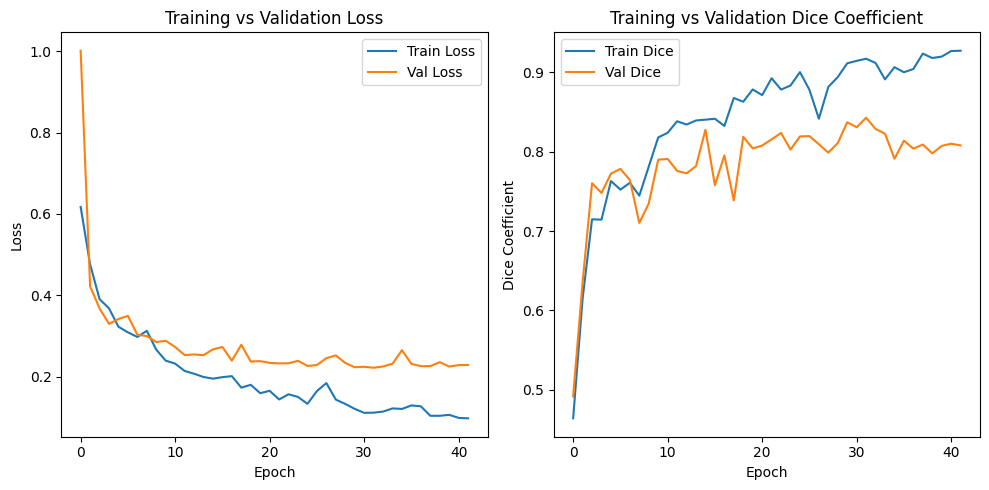

Test F1 Score: 0.84074131707891
Test Dice Coefficient: 0.8407413363456726
Test Accuracy: 0.9173839938256049


In [32]:
if __name__ == "__main__":
    y_train_reshaped = np.expand_dims(train_labels, axis=-1)
    y_val_reshaped = np.expand_dims(val_labels, axis=-1)
    y_test_reshaped = np.expand_dims(test_labels, axis=-1)

    train_loader, val_loader = prepare_data(train_images, y_train_reshaped, val_images, y_val_reshaped)
    test_loader = prepare_test_data(test_images, y_test_reshaped)


    model = UNetModel('resnet34')
    train(model, train_loader, val_loader)
    
    evaluate_on_test(model, test_loader)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import segmentation_models_pytorch as smp
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score as f1_score_sklearn


class UNetModel(nn.Module):
    def __init__(self, encoder):
        super(UNetModel, self).__init__()
        self.pre_conv = nn.Conv2d(12, 3, kernel_size=1)
        nn.BatchNorm2d(3),  
        nn.Dropout(0.1)      
        self.unet = smp.Unet(
            encoder_name=encoder,
            encoder_weights='imagenet',
            in_channels=3,
            classes=1,
            activation=None
        )

    def forward(self, x):
        x = self.pre_conv(x)
        return self.unet(x)

class DiceCoefficient(nn.Module):
    def __init__(self):
        super(DiceCoefficient, self).__init__()

    def forward(self, y_pred, y_true):
        y_pred = y_pred > 0.5 
        y_true = y_true.byte()  
        y_pred_flat = torch.flatten(y_pred)
        y_true_flat = torch.flatten(y_true)
        intersection = torch.sum(y_pred_flat * y_true_flat).float()
        union = torch.sum(y_pred_flat) + torch.sum(y_true_flat).float()
        dice= (2. * intersection + 1e-8) / (union + 1e-8)
        return dice
    
def prepare_data(X_train, y_train, X_val, y_val):
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).squeeze(-1)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).permute(0, 3, 1, 2)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).squeeze(-1)
    
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    
    return train_loader, val_loader

def calculate_f1_score(y_true, y_pred):
    return f1_score_sklearn(y_true.flatten(), y_pred.flatten() > 0.5)

def calculate_accuracy(y_true, y_pred):
    return accuracy_score(y_true.flatten(), y_pred.flatten() > 0.5)

def train(model, train_loader, val_loader, num_epochs=50, patience=10):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
    early_stopping_counter = 0
    best_val_loss = float('inf')
    best_model_state = None
    
    train_losses = []
    val_losses = []
    train_dice_scores = []
    val_dice_scores = []
    dice_coeff = DiceCoefficient()
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        dice_sum = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.view_as(outputs))
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            dice_sum += dice_coeff(torch.sigmoid(outputs), labels).item()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_dice = dice_sum / len(train_loader)
        train_losses.append(epoch_loss)
        train_dice_scores.append(epoch_dice)

        model.eval()
        val_loss = 0.0
        val_dice = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels.view_as(outputs))
                val_loss += loss.item() * inputs.size(0)
                val_dice += dice_coeff(torch.sigmoid(outputs), labels).item()
        
        val_loss /= len(val_loader.dataset)
        val_dice /= len(val_loader)
        val_losses.append(val_loss)
        val_dice_scores.append(val_dice)
        scheduler.step(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Train Dice: {epoch_dice:.4f}, Val Dice: {val_dice:.4f}')
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
        
        if early_stopping_counter >= patience:
            break
    
    if best_model_state:
        model.load_state_dict(best_model_state)
        torch.save(best_model_state, 'best_unet_model.pth')
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_dice_scores, label='Train Dice')
    plt.plot(val_dice_scores, label='Val Dice')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Coefficient')
    plt.title('Training vs Validation Dice Coefficient')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


In [50]:
def evaluate_on_test(model, test_loader):
    model.eval()
    with torch.no_grad():
        all_preds = []
        all_labels = []
        for inputs, labels in test_loader:
            outputs = model(inputs)
            preds = torch.sigmoid(outputs)  
            
            # Ensure shapes match
            if labels.shape != preds.shape:
                labels = labels.view_as(preds)
            
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
        
        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)
        
        test_f1_score = calculate_f1_score(all_labels, all_preds)
        test_dice = DiceCoefficient()(torch.tensor(all_preds), torch.tensor(all_labels))
        test_accuracy = calculate_accuracy(all_labels, all_preds)
        
        print(f'Test F1 Score: {test_f1_score}')
        print(f'Test Dice Coefficient: {test_dice.item()}')
        print(f'Test Accuracy: {test_accuracy}')

def prepare_test_data(X_test, y_test):
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).squeeze(-1)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
    return test_loader

Epoch 1/50, Train Loss: 0.8316, Val Loss: 0.7500, Train Dice: 0.4307, Val Dice: 0.5399
Epoch 2/50, Train Loss: 0.6132, Val Loss: 0.6232, Train Dice: 0.5600, Val Dice: 0.6244
Epoch 3/50, Train Loss: 0.5276, Val Loss: 0.5357, Train Dice: 0.6961, Val Dice: 0.7275
Epoch 4/50, Train Loss: 0.4825, Val Loss: 0.4715, Train Dice: 0.7340, Val Dice: 0.7783
Epoch 5/50, Train Loss: 0.4501, Val Loss: 0.4250, Train Dice: 0.7568, Val Dice: 0.7997
Epoch 6/50, Train Loss: 0.4178, Val Loss: 0.4163, Train Dice: 0.7854, Val Dice: 0.8095
Epoch 7/50, Train Loss: 0.3998, Val Loss: 0.3992, Train Dice: 0.7903, Val Dice: 0.8328
Epoch 8/50, Train Loss: 0.3794, Val Loss: 0.3961, Train Dice: 0.8050, Val Dice: 0.8217
Epoch 9/50, Train Loss: 0.3659, Val Loss: 0.3592, Train Dice: 0.7914, Val Dice: 0.8479
Epoch 10/50, Train Loss: 0.3446, Val Loss: 0.3474, Train Dice: 0.8242, Val Dice: 0.8452
Epoch 11/50, Train Loss: 0.3383, Val Loss: 0.3452, Train Dice: 0.8197, Val Dice: 0.8482
Epoch 12/50, Train Loss: 0.3242, Val Loss

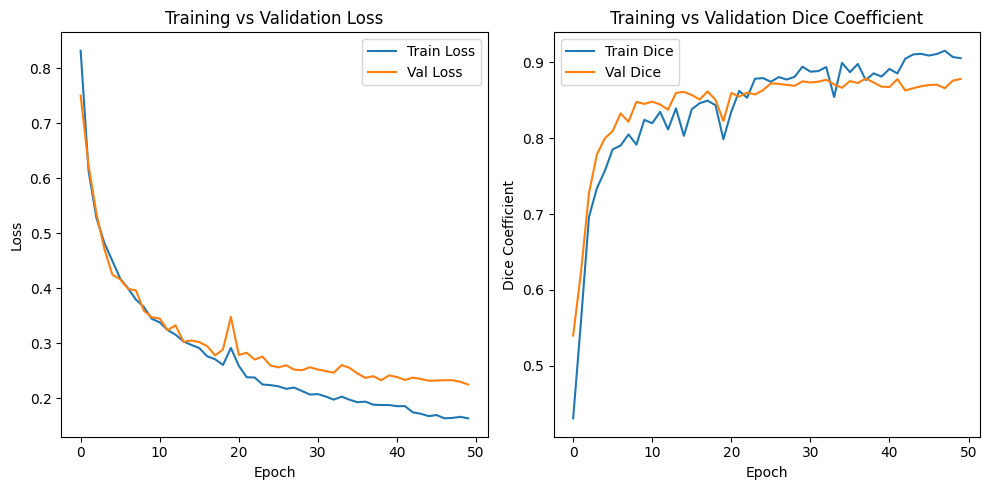

Test F1 Score: 0.8156593384574694
Test Dice Coefficient: 0.8156593441963196
Test Accuracy: 0.9094317036290323


In [51]:
if __name__ == "__main__":
    y_train_reshaped = np.expand_dims(train_labels, axis=-1)
    y_val_reshaped = np.expand_dims(val_labels, axis=-1)
    y_test_reshaped = np.expand_dims(test_labels, axis=-1)

    train_loader, val_loader = prepare_data(train_images, y_train_reshaped, val_images, y_val_reshaped)
    test_loader = prepare_test_data(test_images, y_test_reshaped)


    model = UNetModel('resnet34')
    train(model, train_loader, val_loader)
    
    evaluate_on_test(model, test_loader)
